# Crank-Nicolson With Rannacher Smoothing
### Colin Alberts

## 0: Importing Packages and Defining Variables

### 0.0: Importing Packages

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import copy

import plotly.graph_objs as go
import matplotlib.pyplot as plt

from itertools import product

import warnings
warnings.filterwarnings('ignore')

### 0.1: Defining Acronyms

| Barrier Acronym | Barrier Name |
|-----------------|-----------------|
| UIC | Up-and-In Call |
| UIP | Up-and-In Put |
| UOC | Up-and-Out Call |
| UOP | Up-and-Out Put |
| DIC | Down-and-In Call |
| DIP | Down-and-In Put |
| DOC | Down-and-Out Call |
| DOP | Down-and-Out Put |

In [2]:
T = 1               # expiry time
r = 0.1             # no-risk interest rate
sigma = 0.3         # volatility of underlying asset
delta = 0.0         # dividend rate
E = 100.            # exercise price
S_max = 2 * E       # upper bound of price of the stock (chosen somewhat arbitrarily, unlikely a security will double in price)
S_min = 0
B = 120             # barrier price
N = int(T * 100)    # time iterations
M = int(S_max * 4)  # space iterations, accurate to about 25 cents
option_type = "Euro Call"

In [3]:
# time grid
ht = T / N
ht_small = ht / 4
t_end = np.linspace(start = T - ht,
                    stop = T,
                    num = 5)
t_start = np.linspace(start = 0,
                      stop = T - ht,
                      num = N - 1,
                      endpoint = False)
t = np.concatenate((t_start, t_end))

# spatial grid (stock's price)
s, hs = np.linspace(0,
                    S_max,
                    M + 1,
                    retstep = True)


def initial_condition(x, option):
    x_copy = x
    
    # control flow is basic/slower but sensible
    if option == "Euro Call":
        x_copy[:, -1] = np.maximum(s - E, 0)
        x_copy[0, :] = 0
        x_copy[-1, :] = np.exp(-r * (T - t)) * (S_max - E)
    elif option == "Euro Put":
        x_copy[:, -1] = np.maximum(E - s, 0)
        x_copy[0, :] = np.exp(-r * (T - t)) * (E - S_min)
        x_copy[-1, :] = 0
    elif option in ["DOC", "DIC"]:
        x_copy[:, -1] = np.maximum(s - E, 0) * np.where(s >= B, 1, 0)
        x_copy[0, :] = 0
        x_copy[-1, :] = np.exp(-r * (T - t)) * (S_max - E)
    elif option in ["UOC", "UIC"]:
        x_copy[:, -1] = np.maximum(s - E, 0) * np.where(s <= B, 1, 0)
        x_copy[0, :] = x_copy[-1, :] = 0
    elif option in ["DOP", "DIP"]:
        x_copy[:, -1] = np.maximum(E - s, 0) * np.where(s >= B, 1, 0)
        x_copy[0, :] = x_copy[-1, :] = 0
    elif option in ["UOP", "UIP"]:
        x_copy[:, -1] = np.maximum(E - s, 0) * np.where(s <= B, 1, 0)
        x_copy[0, :] = np.exp(-r * (T - t)) * (E - S_min)
        x_copy[-1, :] = 0

    return x_copy

# solution grid
solution = np.zeros(shape = (M + 1, N + 1 + 3)) # the extra 3 is for Rannacher smoothing
solution = initial_condition(solution, option_type)

# averaging at strike to preserve second-order accuracy in Crank-Nicolson
solution[int(np.ceil(M / 2))][-1] = (solution[int(np.ceil(M / 2)) - 1][-1] + solution[int(np.ceil(M / 2)) + 1][-1]) / 2

# averaging at the barrier
if option_type in ["UIC", "UOC", "DIC", "DOC",  "UIP", "UOP", "DIP", "DOP"]:
    if B in s:
        B_index = np.where(s == B)[0]
        solution[B_index][-1] = (solution[B_index - 1][-1] + solution[B_index + 1][-1]) / 2
    else:
        # this is more concise than writing out a binary search
        B_right_index = np.searchsorted(s, B)
        B_left_index = B_right_index - 1
        
        # have to store temporary variables since I will be using each to average the other
        temp = solution[B_right_index][-1]
        solution[B_right_index][-1] = (solution[B_right_index - 1][-1] + solution[B_right_index + 1][-1]) / 2
        solution[B_left_index][-1] = (solution[B_left_index - 1][-1] + temp) / 2

### 0.2: Optimization Functions

I used the Thomas Algorithm implementation from [this](https://github.com/katpirat/Finite-difference-for-PDEs/blob/main/FD_for_BlackScholes_pricing.py) repo.

In [4]:
# Thomas Algorithm, is only stable when matrix is diagonally dominant or SPD.
def thomas(a, b, c, d):
    dim = len(d)  # number of equations to be solved
    ac, bc, cc, dc = map(np.array, (a, b, c, d))
    
    for i in range(1, dim):
        w = ac[i - 1] / bc[i - 1]
        bc[i] = bc[i] - w * cc[i - 1]
        dc[i] = dc[i] - w * dc[i - 1]
        
    x = bc
    x[-1] = dc[-1] / bc[-1]

    for j in range(dim - 2, -1, -1):
        x[j] = (dc[j] - cc[j] * x[j + 1]) / bc[j]
        
    return x

I check for diagonal dominance in the matrix that I solve the system with. If it is not diagonally dominant then bad things happen (convergence issues, instability, increased computation cost, etc.).

In [5]:
# Checking diagonal dominance for Thomas Algorithm stability
def check_diag_dominant(mat):
    diags = np.abs(np.diag(mat))
    return np.all(diags >= np.sum(np.abs(mat), axis=1).T - diags)

Successive over-relaxation method is used for BDF2. I used the implementation from [this](https://stackoverflow.com/questions/53251299/successive-over-relaxation) StackOverflow post.

In [ ]:
# Successive over-relaxation implementation
def sor(A, b, omega, initial_guess, convergence_criteria):
  
  phi = initial_guess[:]
  residual = np.linalg.norm(np.matmul(A, phi) - b) # Initial residual
  
  while residual > convergence_criteria:
    for i in range(A.shape[0]):
      sigma = 0
      
      for j in range(A.shape[1]):
        if j != i:
          sigma += A[i][j] * phi[j]
          
      phi[i] = (1 - omega) * phi[i] + (omega / A[i][i]) * (b[i] - sigma)
      
    residual = np.linalg.norm(np.matmul(A, phi) - b)
  return phi

# 1: Implementation

## 1.1: Methods

### 1.1.0: Empirical

In [6]:
def empirical(s, sigma, r, delta, option, time):
    solution = np.zeros(shape = (s.shape[0], time.shape[0]))
    
    for i, current_s in enumerate(s):
        d_1 = (np.log(current_s / E) + (r - delta + sigma ** 2 / 2) * (T - time)) / (sigma * np.sqrt(T - time))
        d_2 = d_1 - sigma * np.sqrt(T - time)
        
        if option in ["Euro Call", "UIC", "DIC"]:
            solution[i, :] = current_s * np.exp(-delta * (T - time)) * norm.cdf(d_1) - E * np.exp(-sigma * (T - time)) * norm.cdf(d_2)
        elif option in ["Euro Put", "UIP", "DIP"]:
            solution[i, :] = E * np.exp(-sigma * (T - time)) * norm.cdf(-d_2) - current_s * np.exp(-delta * (T - time)) * norm.cdf(-d_1)
    
    return solution

### 1.1.1: Crank-Nicolson with Rannacher Smoothing

The [link](https://www.researchgate.net/publication/228524629_Convergence_analysis_of_Crank-Nicolson_and_Rannacher_time-marching) that explains why I used quarter steps for ONE iteration in the Rannacher smoothing. See the last paragraph of page 107.

Read [this](http://www.goddardconsulting.ca/option-pricing-finite-diff-crank-nicolson.html) to learn more about Crank-Nicolson differencing for Black-Scholes-Merton.

In [7]:
def crank_smoothed(s, sigma, r, delta, solution, option):
    crank_solution = copy.deepcopy(solution)
    
    # Crank-Nicolson vectors
    u_vec = (sigma ** 2 * s ** 2) / (4 * hs ** 2) - (r - delta) * s / (4 * hs)
    v_vec = (sigma ** 2 * s ** 2) / (2 * hs ** 2) + r / 2
    w_vec = (sigma ** 2 * s ** 2) / (4 * hs ** 2) + (r - delta) * s / (4 * hs)
    
    P_mat_C = -np.diag(u_vec[2:-1] * ht, -1) + np.diag(v_vec[1:-1] * ht) - np.diag(w_vec[1:-2] * ht, 1) + np.identity(M - 1)
    
    offset_1 = np.zeros(M - 1)
    offset_2 = np.zeros(M - 1)
    
    # Backward Euler setup
    alpha = ht_small * (-sigma ** 2 * s ** 2 / hs ** 2 + s * (r - delta)/ hs) / 2
    beta = ht_small * (r + sigma ** 2 * s ** 2 / hs ** 2)
    gamma = ht_small * (-s ** 2 * sigma ** 2 / hs ** 2 - s * (r - delta)/ hs) / 2
    
    P_mat_E = np.diag(alpha[2:-1], -1) + np.diag(beta[1:-1]) + np.diag(gamma[1:-2], 1) + np.identity(M - 1)
    
    offset = np.zeros(M - 1)
    
    for i in range(N + 3, 0, -1):
        if i > N - 1:
            if not check_diag_dominant(P_mat_E):
                print("Matrix is NOT diagonally dominant!!!")
            
            offset[0], offset[-1] = crank_solution[0, i] * alpha[1], crank_solution[-1, i] * gamma[-1]
            
        
            crank_solution[1:-1, i - 1] = thomas(np.diag(P_mat_E, -1),
                                                 np.diag(P_mat_E),
                                                 np.diag(P_mat_E, 1),
                                                 crank_solution[1:-1, i] - offset)
            
        else:
            if not check_diag_dominant(P_mat_C):
                print("Matrix is NOT diagonally dominant!!!")
                
            offset_1[0] = crank_solution[0, i] * u_vec[1] * -2
            offset_1[-1] = crank_solution[-1, i] * w_vec[-1] * -2

            offset_2[0] = crank_solution[0, i - 1] * u_vec[1] * -2
            offset_2[-1] = crank_solution[-1, i - 1] * w_vec[-1] * -2
            
            Q_mat = np.diag(u_vec[2:-1] * ht, -1) - np.diag(v_vec[1:-1] * ht) + np.diag(w_vec[1:-2] * ht, 1) + np.identity(M - 1)
            RHS = np.dot(Q_mat, crank_solution[1:-1, i]) - ht / 2 * (offset_1 + offset_2)
                
            crank_solution[1:-1, i - 1] = thomas(np.diag(P_mat_C, -1),
                                                np.diag(P_mat_C),
                                                np.diag(P_mat_C, 1),
                                                RHS)
    
    # keeping pass in for sanity check
    if option_type in ["UOC", "UOP", "DOC", "DOP"]:
        pass
    elif option_type in ["UIC", "DIP", "UIP", "DIC"]:
        crank_solution = empirical(s, sigma, r, delta, option, t) - crank_solution
        
    df = pd.DataFrame(crank_solution, columns = list(map(lambda i: str(ht * i), 
                                                         range(crank_solution.shape[1]))))

    return df

### 1.1.2: Crank-Nicolson (plain)
Want Crank-Nicolson without smoothing for comparison purposes.

In [8]:
def crank(s, sigma, r, delta, solution, option):
    crank_solution = copy.deepcopy(solution)
    
    # Crank-Nicolson vectors
    u_vec = (sigma ** 2 * s ** 2) / (4 * hs ** 2) - (r - delta) * s / (4 * hs)
    v_vec = (sigma ** 2 * s ** 2) / (2 * hs ** 2) + r / 2
    w_vec = (sigma ** 2 * s ** 2) / (4 * hs ** 2) + (r - delta) * s / (4 * hs)
    
    P_mat_C = -np.diag(u_vec[2:-1] * ht, -1) + np.diag(v_vec[1:-1] * ht) - np.diag(w_vec[1:-2] * ht, 1) + np.identity(M - 1)
    
    offset_1 = np.zeros(M - 1)
    offset_2 = np.zeros(M - 1)
    
    for i in range(N, 0, -1):
        if not check_diag_dominant(P_mat_C):
                print("Matrix is NOT diagonally dominant!!!")
                
        offset_1[0] = crank_solution[0, i] * u_vec[1] * -2
        offset_1[-1] = crank_solution[-1, i] * w_vec[-1] * -2

        offset_2[0] = crank_solution[0, i - 1] * u_vec[1] * -2
        offset_2[-1] = crank_solution[-1, i - 1] * w_vec[-1] * -2
            
        Q_mat = np.diag(u_vec[2:-1] * ht, -1) - np.diag(v_vec[1:-1] * ht) + np.diag(w_vec[1:-2] * ht, 1) + np.identity(M - 1)
        RHS = np.dot(Q_mat, crank_solution[1:-1, i]) - ht / 2 * (offset_1 + offset_2)
                
        crank_solution[1:-1, i - 1] = thomas(np.diag(P_mat_C, -1),
                                             np.diag(P_mat_C),
                                             np.diag(P_mat_C, 1),
                                             RHS)
    
    # keeping pass in for sanity check
    if option_type in ["UOC", "UOP", "DOC", "DOP"]:
        pass
    elif option_type in ["UIC", "DIC", "UIP", "DIP"]:
        crank_solution = empirical(s, sigma, r, delta, option, t) - crank_solution
        
    df = pd.DataFrame(crank_solution, columns = list(map(lambda i: str(ht * i), 
                                                         range(crank_solution.shape[1]))))

    return df

### 1.1.3: Backward Differentiation Formula 2 (BDF2) 
Also known as the second-order accurate backward differencing scheme.

In [ ]:
def bdf2(s, sigma, r, delta, solution, option):
    print(1)

## 1.2: Plot Function

In [9]:
def surface_plot(solution):
    X, Y = np.meshgrid(t[::-1], s)
    
    fig = go.Figure(data=[go.Surface(z=solution, x=Y, y=X)])
    
    fig.update_layout(title='Price Surface', 
                      autosize=False,
                      scene=dict(xaxis_title='Price',
                                 yaxis_title='Time',
                                 zaxis_title='Payoff'))
    fig.show()

## 1.3: Greeks

Vega (*v*) and rho ($\rho$) were omitted since we assume volatility and interest rate are constant. This is not realistic since these fluctuate; will omit for now.

### 1.3.1: Delta

$\Delta = \frac{\partial V}{\partial S}$. Sensitivity of option price with respect to price of the underlying.

In [10]:
# input is solution grid, solution[price, time]
def delta_greek(prices):
    x, y = prices.shape
    delta_matrix = np.zeros((x, y))
    
    # forward differencing for price = 0
    delta_matrix[0, :] = (prices[1, :].T - prices[0, :].T) / hs
    
    # backward differencing for price = S_max
    delta_matrix[-1, :] = (prices[-1, :].T - prices[-2, :].T) / hs
    
    # indexing to simplify centered differencing
    K = np.arange(1, x - 1)
    
    # centered differencing for prices (0, S_max)
    delta_matrix[K, :] = (prices[(K + 1), :] - prices[(K - 1), :]) / (2 * hs)
    
    return delta_matrix[:-2, :]

In [11]:
# print(delta_greek(np.matrix(crank_sol)))
# temp_sol = crank_sol.values
# temp_delta = delta_greek(temp_sol)
# surface_plot(temp_delta)

### 1.3.2: Gamma

$\Gamma = \frac{\partial\Delta}{\partial S} = \frac{\partial ^ 2 V}{\partial S ^ 2}$

This is right but it looks weird because it makes sense if you zoom into the iterations. Looks similar to a normal curve with high variance.

Sensitivity of $\Delta$ with respect to the underlying price = concavity of option price with respect to price of the underlying.

In [12]:
# input is solution grid, solution[price, time]
def gamma_greek(prices):
    x, y = prices.shape
    gamma_matrix = np.zeros((x, y))
    
    # indexing to simplify centered differencing
    K = np.arange(1, x - 1)
    
    # centered differencing for prices [0, S_max]
    gamma_matrix[K, :] = (prices[(K + 1), :] - 2 * prices[K, :] + prices[(K - 1), :]) / (hs ** 2)
    
    return gamma_matrix[:-2, :]

In [13]:
# surface_plot(gamma_greek(crank_sol.values))

### 1.3.3: Theta
$\Theta = - \frac{\partial V}{\partial\tau}$. Sensitivity of option price with respect to time to expiry.

In [14]:
# input is solution grid, solution[price, time]
def theta_greek(prices):
    x, y = prices.shape
    theta_matrix = np.zeros((x, y))
    
    # indexing to simplify centered differencing
    K = np.arange(1, y - 1)
    
    # centered differencing for times [0, T]
    theta_matrix[:, K] = (prices[:, (K - 1)] - prices[:, (K + 1)]) / (2 * (t[K + 1] - t[K - 1]))
    
    return theta_matrix[:, 1:-1]

In [15]:
# surface_plot(theta_greek(crank_sol.values))

### 1.3.4: Lambda
ABANDONED THIS GREEK!!!!!!!!!!!!!!!

$\lambda = \Delta * \frac{S}{V} = \frac{\partial V}{\partial S} * \frac{S}{V}$. Option leverage = change in the option value per $1\%$ change in the underlying.

In [16]:
# # input is solution grid, solution[price, time]
# def lambda_greek(prices):
#     x, y = prices.shape
#     lambda_matrix = np.zeros((x, y))
    
#     # forward differencing for price = 0
#     lambda_matrix[0, :] = (prices[1, :].T - prices[0, :].T) / hs
    
#     # backward differencing for price = S_max
#     lambda_matrix[-1, :] = (prices[-1, :].T - prices[-2, :].T) / hs
    
#     # indexing to simplify centered differencing
#     K = np.arange(1, x - 1)
    
#     # centered differencing for prices (0, S_max)
#     lambda_matrix[K, :] = (prices[(K + 1), :] - prices[(K - 1), :]) / (2 * hs)
    
#     return lambda_matrix * s[K, :] / prices[K, :]

# 2: Plots

## 2.1: CN with Rannacher

In [17]:
crank_sol = crank_smoothed(s, sigma, r, delta, solution, option_type)

surface_plot(crank_sol)

In [18]:
# something is going on with the spurious oscillations of the system
# are attemping to apply BE to make the oscillations go away
crank_cross_section_data = crank_sol.iloc[-2, :]
# crank_cross_section, = plt.plot(t, crank_cross_section_data, color = "red", label = "CN with Rannacher steps")

## 2.2: CN

In [19]:
# need to reset t and grid for following methods
t = np.linspace(start = 0,
                stop = T,
                num = N + 1)
# solution grid
solution = np.zeros(shape = (M + 1, N + 1))
solution = initial_condition(solution, option_type)

In [20]:
plain_crank_sol = crank(s, sigma, r, delta, solution, option_type)
# surface_plot(plain_crank_sol)

In [21]:
plain_crank_cross_section_data = plain_crank_sol.iloc[-2, :]
# plain_crank_cross_section, = plt.plot(t, plain_crank_cross_section_data, color = "green", label = "Regular CN")

## 2.3: Empirical

In [22]:
# empirical_sol = empirical(s, sigma, r, delta, "Euro Call", t)
# surface_plot(empirical_sol)

# 3: Error Analysis
All analysis will be for European Call option.

## 3.1: Generating Crank-Nicolson vs Crank-Nicolson with Rannacher Smoothing Data

### 3.1.1: Initializing Data Frame

In [23]:
# # risk-free and volatility grid
# r_grid = np.linspace(0.01, 0.2, 20)
# sigma_grid = np.linspace(0.01, 0.8, 80)

# # initializing data frame
# error_df = pd.DataFrame({"Risk-Free Rate": np.concatenate((r_grid, [0.1 for i in range(len(sigma_grid))])),
#                          "Implied Volatility": np.concatenate(([0.3 for i in range(len(r_grid))], sigma_grid))})
# # error_df["Relative Error CN"] = error_df["Relative Error CNwRS"] = float("inf")

### 3.1.2: Relative Error Function

In [24]:
# Will make it easier to vectorize
def relative_error(df, method):
    global s
    global t
    global solution
    
    empirical_val = empirical(s, 
                              df["Implied Volatility"], 
                              df["Risk-Free Rate"], 
                              delta = 0, 
                              option = "Euro Call", 
                              time = t)
    if method == "CNwRS":
        approximate_val = crank_smoothed(s, 
                                         df["Implied Volatility"], 
                                         df["Risk-Free Rate"], 
                                         delta = 0, 
                                         solution = solution, 
                                         option = "Euro Call")
    else:
        approximate_val = crank(s, 
                                df["Implied Volatility"], 
                                df["Risk-Free Rate"], 
                                delta = 0, 
                                solution = solution, 
                                option = "Euro Call")
    
    return np.sum(np.sum(np.abs(np.nan_to_num(empirical_val - approximate_val)))) / np.sum(np.sum(np.abs(np.nan_to_num(empirical_val))))

### 3.1.3: Calculating Relative Error

In [25]:
# # This could be more efficient using a more slick function and vectorization; this is fine for now.

# # iterating through rows and calculating relative error
# for index, row in error_df.iterrows():
#     error_df.at[index, 'Relative Error CNwRS'] = relative_error(row, "CNwRS")
    
# # need to reset t and grid for plain Crank-Nicolson
# t = np.linspace(start = 0, stop = T, num = N + 1); solution = np.zeros(shape = (M + 1, N + 1)); solution = initial_condition(solution, option_type)

# for index, row in error_df.iterrows():
#     error_df.at[index, 'Relative Error CN'] = relative_error(row, "CN")

### 3.1.4: Calculating Error Difference Between CNwRS and CN

In [26]:
# # finding difference between CN and CNwRS
# error_df["Error Diff"] = error_df["Relative Error CNwRS"] - error_df["Relative Error CN"]

### 3.1.5: Saving DataFrame to csv

In [27]:
# saving df; compute is long
# error_df.to_csv('relative_error_comparison.csv', index=False) 

## 3.2: Error Analysis
Negative "Error Diff" means that the method with Rannacher smoothing is more accurate.

### 3.2.0: Importing Data

In [28]:
error_df = pd.read_csv("relative_error_comparison.csv")

### 3.2.1: Risk-Free Rate Analysis

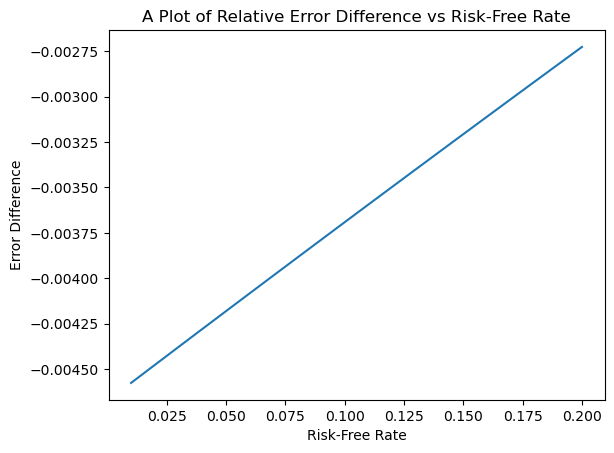

The smallest difference between Crank-Nicolson and Crank-Nicolson with Rannacher Smoothing occurs when r =  0.2


In [29]:
# filtering so implied volatility is constant
risk_free_error_df = error_df.loc[error_df["Implied Volatility"] == 0.3]
risk_free_error_df = risk_free_error_df[:-1] # drop_duplicates was not working for some reason

# risk-free error diff
plt.plot(risk_free_error_df["Risk-Free Rate"], risk_free_error_df["Error Diff"])
plt.xlabel('Risk-Free Rate')
plt.ylabel('Error Difference')
plt.title('A Plot of Relative Error Difference vs Risk-Free Rate')
plt.show()

biggest_index = np.argmax(risk_free_error_df["Error Diff"])
print("The smallest difference between Crank-Nicolson and Crank-Nicolson with Rannacher Smoothing occurs when r = ", np.round(np.array(risk_free_error_df["Risk-Free Rate"])[biggest_index], 5))

This implies that as the risk-free rate increases from $0$ to $1$ that the difference in error between Crank-Nicolson and Crank-Nicolson with Rannacher smoothing tends to $0$ in a linear manner. It seems as though it would become positive if the risk-free rate becomes great enough. This is unlikely to occur since risk-free rate is nearly always under $20\%$.

### 3.2.2: Implied Volatility Analysis

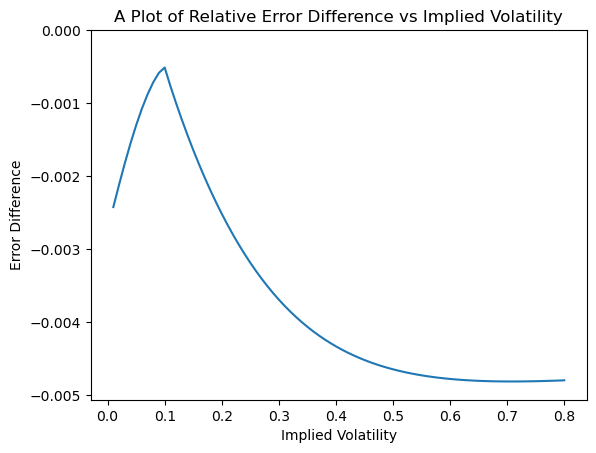

The smallest difference between Crank-Nicolson and Crank-Nicolson with Rannacher Smoothing occurs when sigma =  0.1


In [30]:
# filtering so implied volatility is constant
vol_error_df = error_df.loc[error_df["Risk-Free Rate"] == 0.1]

# risk-free error diff
plt.plot(vol_error_df["Implied Volatility"], vol_error_df["Error Diff"])
plt.xlabel('Implied Volatility')
plt.ylabel('Error Difference')
plt.title('A Plot of Relative Error Difference vs Implied Volatility')
plt.ylim(min(vol_error_df["Error Diff"]) - 0.00025, 0)
plt.show()

biggest_index = np.argmax(vol_error_df["Error Diff"])
print("The smallest difference between Crank-Nicolson and Crank-Nicolson with Rannacher Smoothing occurs when sigma = ", np.round(np.array(vol_error_df["Implied Volatility"])[biggest_index], 5))

This shows that the difference in error between the methods converges to around $0.5\%$ as implied volatility converges to $1$ and achieves a maximum where implied volatility is $10\%$.

### 3.2.3: Comparing Method Oscillations

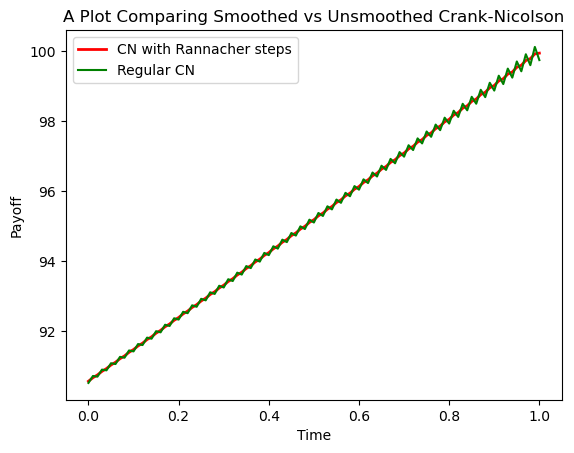

In [31]:
plt.plot(t, crank_cross_section_data[:-3], color = "red", label = "CN with Rannacher steps", linewidth = 2)
plt.plot(t, plain_crank_cross_section_data, color = "green", label = "Regular CN")

plt.legend(loc = "upper left")

plt.xlabel('Time')
plt.ylabel('Payoff')
plt.title('A Plot Comparing Smoothed vs Unsmoothed Crank-Nicolson')

plt.show()

Shows regular Crank-Nicolson's oscillations. The lack of (significant) oscillations with Rannacher smoothing increases accuracy.

### 3.2.4: Crank-Nicolson Error Analysis

#### 3.2.4.1: Risk-Free Rate Varies

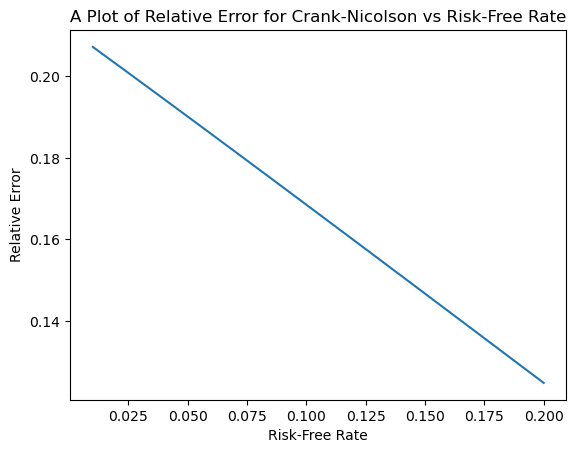

count    20.000000
mean      0.166201
std       0.025701
min       0.124768
25%       0.145580
50%       0.166317
75%       0.186898
max       0.207230
Name: Relative Error CN, dtype: float64

In [32]:
cn_relative_error_r = risk_free_error_df["Relative Error CN"]

plt.plot(risk_free_error_df["Risk-Free Rate"], cn_relative_error_r)

plt.xlabel('Risk-Free Rate')
plt.ylabel('Relative Error')
plt.title('A Plot of Relative Error for Crank-Nicolson vs Risk-Free Rate')

plt.show()

cn_relative_error_r.describe()

Relative error decreases linearly as risk-free rate increases.

#### 3.2.4.2: Implied Volatility Varies

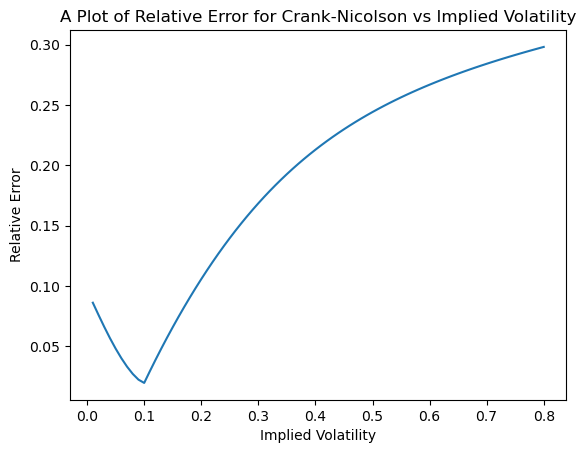

count    80.000000
mean      0.188665
std       0.089298
min       0.019675
25%       0.111119
50%       0.214676
75%       0.267216
max       0.298016
Name: Relative Error CN, dtype: float64

In [33]:
cn_relative_error_sig = vol_error_df["Relative Error CN"]

plt.plot(vol_error_df["Implied Volatility"], cn_relative_error_sig)

plt.xlabel('Implied Volatility')
plt.ylabel('Relative Error')
plt.title('A Plot of Relative Error for Crank-Nicolson vs Implied Volatility')

plt.show()

cn_relative_error_sig.describe()

Relative error tends to increase as implied volatility increases in a $\log$-like manner.

### 3.2.5: Crank-Nicolson With Rannacher Smoothing Error Analysis

#### 3.2.5.1: Risk-Free Rate Varies

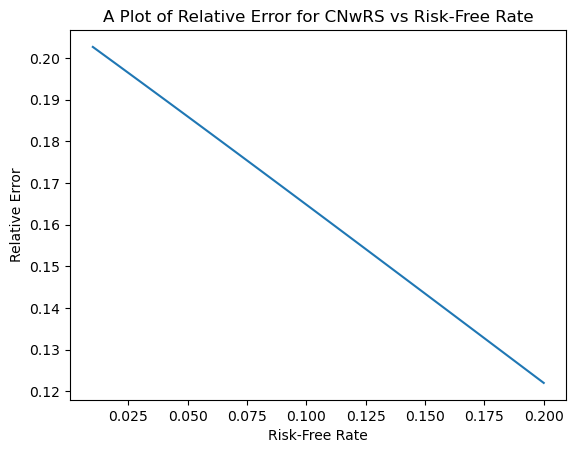

count    20.000000
mean      0.162555
std       0.025126
min       0.122041
25%       0.142397
50%       0.162674
75%       0.182790
max       0.202654
Name: Relative Error CNwRS, dtype: float64

In [34]:
cnrs_relative_error_r = risk_free_error_df["Relative Error CNwRS"]

plt.plot(risk_free_error_df["Risk-Free Rate"], cnrs_relative_error_r)

plt.xlabel('Risk-Free Rate')
plt.ylabel('Relative Error')
plt.title('A Plot of Relative Error for CNwRS vs Risk-Free Rate')

plt.show()

cnrs_relative_error_r.describe()

Decreases linearly, similar to plain Crank-Nicolson case. Error is slightly less.

#### 3.2.5.2: Implied Volatility Varies

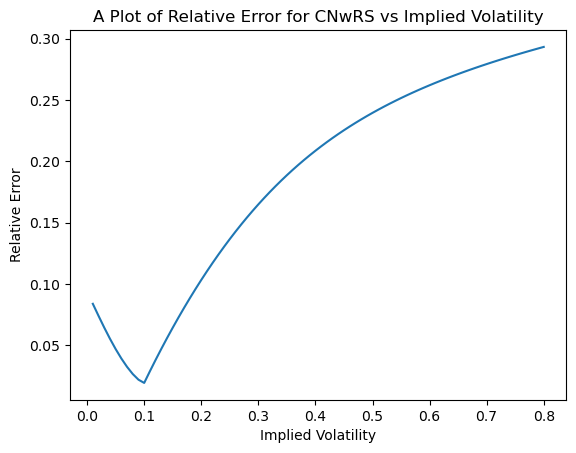

count    80.000000
mean      0.185021
std       0.087944
min       0.019162
25%       0.108492
50%       0.210324
75%       0.262437
max       0.293220
Name: Relative Error CNwRS, dtype: float64

In [35]:
cnrs_relative_error_sig = vol_error_df["Relative Error CNwRS"]

plt.plot(vol_error_df["Implied Volatility"], cnrs_relative_error_sig)

plt.xlabel('Implied Volatility')
plt.ylabel('Relative Error')
plt.title('A Plot of Relative Error for CNwRS vs Implied Volatility')

plt.show()

cnrs_relative_error_sig.describe()

Similar shape as Crank-Nicolson relative error with slightly lower error values.